In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from ed_rvfl_sc import edRVFL_SC  # Corrected import

# Load California Housing dataset
data = fetch_california_housing()
X, y = data.data, data.target
y = y.reshape(-1, 1)  # Reshape to 2D array

# Split and preprocess data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale features and target
scaler_x = StandardScaler()
X_train = scaler_x.fit_transform(X_train)
X_test = scaler_x.transform(X_test)

scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train)
y_test = scaler_y.transform(y_test)

# Initialize and train model
model = edRVFL_SC(
    num_units=512,
    activation='relu',
    lambda_=0.0001,
    Lmax=7,
    deep_boosting=0.5
)
model.train(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Inverse transform to original scale
y_test_orig = scaler_y.inverse_transform(y_test)
y_pred_orig = scaler_y.inverse_transform(y_pred)



RMSE: 0.5848
R² Score: 0.7390

Layer-wise FLOPs Breakdown:
Layer  Input Dim  D Features W FLOPs      Act FLOPs    Beta FLOPs  
0      9          520        9,216        512          1,040       
1      521        521        533,504      512          1,042       
2      521        1033       533,504      512          2,066       
3      1033       1033       1,057,792    512          2,066       
4      1033       1033       1,057,792    512          2,066       
5      1033       1033       1,057,792    512          2,066       
6      1033       1033       1,057,792    512          2,066       

Total Calculations:
Parameters: 2,659,902
FLOPs: 5,323,388

Total parameters: 2,659,902
FLOPs per prediction: 5,323,388


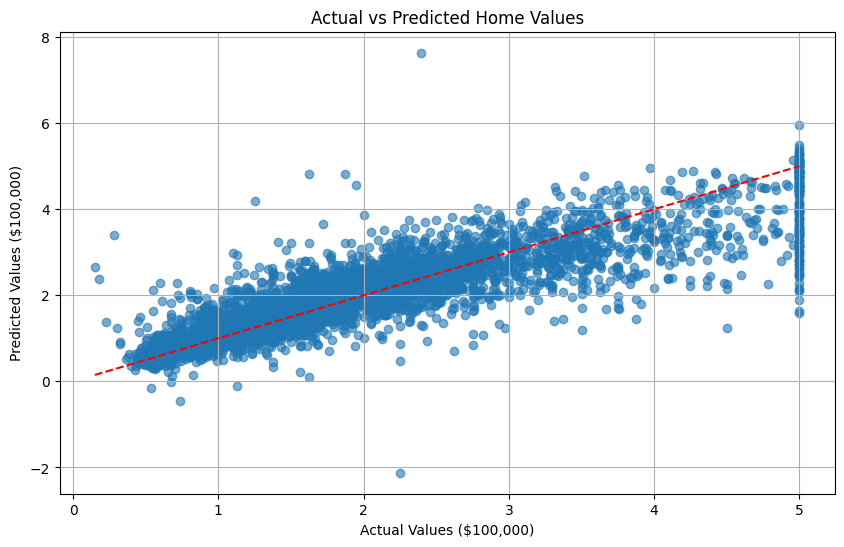

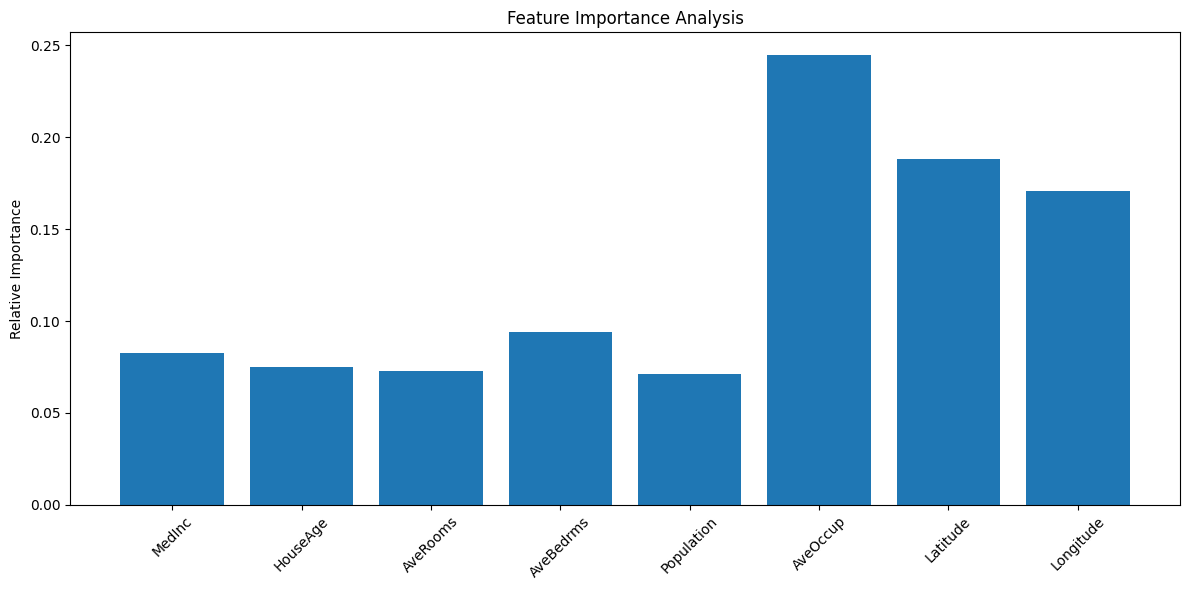

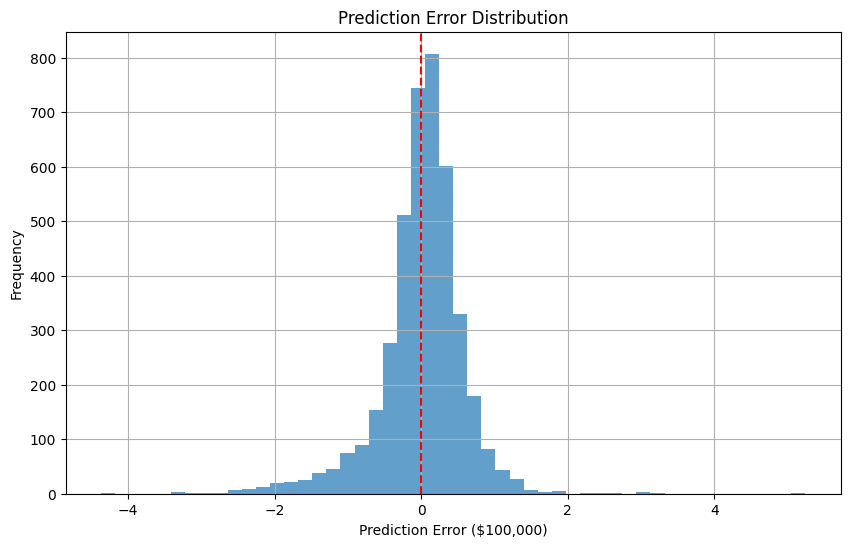

In [2]:
# Calculate metrics
mse = mean_squared_error(y_test_orig, y_pred_orig)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_orig, y_pred_orig)

print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

# Analyze model size
params, flops = model._get_model_size()
print(f"\nTotal parameters: {params:,}")
print(f"FLOPs per prediction: {flops:,}")

# Visualization 1: Actual vs Predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test_orig, y_pred_orig, alpha=0.6)
plt.plot([y_test_orig.min(), y_test_orig.max()], 
         [y_test_orig.min(), y_test_orig.max()], 'r--')
plt.title('Actual vs Predicted Home Values')
plt.xlabel('Actual Values ($100,000)')
plt.ylabel('Predicted Values ($100,000)')
plt.grid(True)
plt.savefig('actual_vs_predicted.png', dpi=300)
plt.show()
feature_importances = np.zeros(X.shape[1])
for beta in model.beta_computed:
    feature_importances += np.abs(beta[:X.shape[1]].mean(axis=1))

# Normalize importance
feature_importances /= feature_importances.sum()

plt.figure(figsize=(12, 6))
plt.bar(range(X.shape[1]), feature_importances)
plt.xticks(range(X.shape[1]), data.feature_names, rotation=45)
plt.title('Feature Importance Analysis')
plt.ylabel('Relative Importance')
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300)
plt.show()

# Visualization 3: Prediction error distribution
errors = y_pred_orig.flatten() - y_test_orig.flatten()
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=50, alpha=0.7)
plt.axvline(x=0, color='r', linestyle='--')
plt.title('Prediction Error Distribution')
plt.xlabel('Prediction Error ($100,000)')
plt.ylabel('Frequency')
plt.grid(True)
plt.savefig('error_distribution.png', dpi=300)
plt.show()